In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Sentence_Transformer/

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/13vPd416qsqqUzoieE2YRwzDjKOGjA_Ay/Sentence_Transformer


In [ ]:
import pandas as pd
train_data = pd.read_csv('./data/test_rand_50.txt', sep='\t', header=None, names=['sentence1', 'sentence2'])
print(f"Number of training samples: {train_data.shape[0]}")


# # Load data in chunks
# train_chunksize = 20000
# val_chunk_size = 2500
# test_chunk_size = 2500

# print(f"Number of training samples: {train_data.shape[0]}")
# train_data = train_data.rename(columns={'target': 'label'})
# val_data = val_data.rename(columns={'target': 'label'})
# test_data = test_data.rename(columns={'target': 'label'})
# print(f"Number of validation samples: {val_data.shape[0]}")
# print(f"Number of test samples: {test_data.shape[0]}")

Number of training samples: 50


In [ ]:
from transformers import pipeline, DistilBertForSequenceClassification, DistilBertTokenizer
import torch

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model and tokenizer
model = DistilBertForSequenceClassification.from_pretrained("./results/mlm_base_checkpoint")
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Make sure the model's config has correct labels
model.config.id2label = {0: 'incorrect', 1: 'correct'}
model.config.label2id = {'incorrect': 0, 'correct': 1}

# Set up the classification pipeline
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer, device=device)

# Example sentences
sentence = "The cat are on the roof."  # Incorrect
correct_sentence = "The cat is on the roof."  # Correct

# Run the classifier
result = classifier(sentence)
correct_result = classifier(correct_sentence)

# Display results
print(f"Prediction for incorrect sentence: {result}")
print(f"Prediction for correct sentence: {correct_result}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Prediction for incorrect sentence: [{'label': 'correct', 'score': 0.8119890093803406}]
Prediction for correct sentence: [{'label': 'correct', 'score': 0.9196574091911316}]


In [ ]:
# prompt: load data from train_data, and classify sentence1 and sentence two separately. print the predictions

# Iterate over the DataFrame and classify sentences
for index, row in train_data.iterrows():
  sentence1 = row['sentence1']
  sentence2 = row['sentence2']

  # Classify sentence1
  result1 = classifier(sentence1)
  print(f"Sentence 1: {sentence1}")
  print(f"Prediction 1: {result1}")

  # Classify sentence2
  result2 = classifier(sentence2)
  print(f"Sentence 2: {sentence2}")
  print(f"Prediction 2: {result2}")
  print("-" * 20)  # Add a separator for clarity


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Sentence 1: You can take a taxi or try a camel ride, very appropriate given the terrain.
Prediction 1: [{'label': 'correct', 'score': 0.6976174712181091}]
Sentence 2: You can take a taxi or try a camel ride, appropriate given the terrain. 
Prediction 2: [{'label': 'correct', 'score': 0.6050970554351807}]
--------------------
Sentence 1: now W.Va. (AP) - Shrinking revenue is forcing Legal Aid of West Virginia to close six satellite offices and lay off 17 employees by January.
Prediction 1: [{'label': 'correct', 'score': 0.7556154131889343}]
Sentence 2: CHARLESTON, W.Va. (AP) - Shrinking revenue is forcing Legal Aid of West Virginia to close six satellite offices and lay off 17 employees by January.
Prediction 2: [{'label': 'correct', 'score': 0.692353367805481}]
--------------------
Sentence 1: Caradog is found collapsed near the table , and Madame thinks he has died , but Odette fires a soda siphon on his face , and the story ends with Caradog warning his son of the dangers of overseas

# Validation


In [2]:
from transformers import pipeline, DistilBertForSequenceClassification, DistilBertTokenizer
import torch
import pandas as pd


# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model and tokenizer
model = DistilBertForSequenceClassification.from_pretrained("./results/mlm_base_checkpoint")
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# Make sure the model's config has correct labels
model.config.id2label = {0: 'incorrect', 1: 'correct'}
model.config.label2id = {'incorrect': 0, 'correct': 1}

# Set up the classification pipeline
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer, device=device)

val_data = pd.read_parquet('./data/val_filtered.parquet')
true_labels = val_data['target'].tolist()
sentences = val_data['sentence'].tolist()

# Collecting predictions and confidence scores
predictions = classifier(sentences, return_all_scores=True)

# Extracting confidence scores for correct class (label=1)
confidence_scores = [max(pred[1]['score'], pred[0]['score']) for pred in predictions]  # Adjust based on label index
predicted_labels = [1 if pred[1]['score'] > pred[0]['score'] else 0 for pred in predictions]

# Compare predictions with true labels
correct_confidences = [score for score, pred, true in zip(confidence_scores, predicted_labels, true_labels) if pred == true]
incorrect_confidences = [score for score, pred, true in zip(confidence_scores, predicted_labels, true_labels) if pred != true]


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [7]:
predictions[0][0]

{'label': 'incorrect', 'score': 0.12209845334291458}

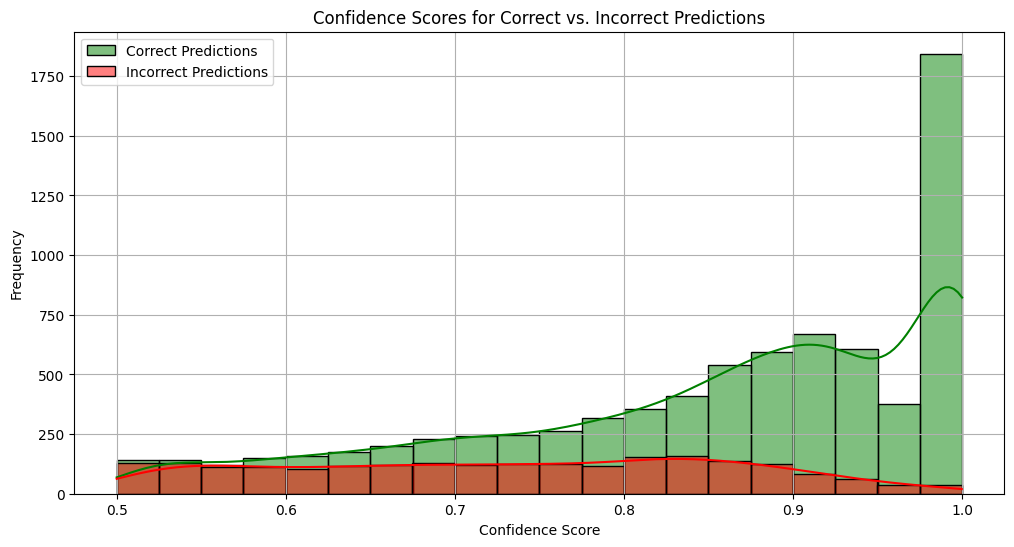

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot histograms of confidence scores for correct vs. incorrect predictions
plt.figure(figsize=(12, 6))
sns.histplot(correct_confidences, bins=20, color='green', label='Correct Predictions', kde=True)
sns.histplot(incorrect_confidences, bins=20, color='red', label='Incorrect Predictions', kde=True)
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.title('Confidence Scores for Correct vs. Incorrect Predictions')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Identify high-confidence errors
high_confidence_errors = [(sent, score) for sent, score, pred, true in zip(sentences, confidence_scores, predicted_labels, true_labels) if pred != true and score > 0.75]  # Adjust threshold

print("High-Confidence Errors:")
for sent, score in high_confidence_errors:
    print(f"Sentence: {sent}, Confidence Score: {score}")


High-Confidence Errors:
Sentence: It will be called upon to continue the work to take us our goal of seeing the Lisbon Treaty enter into force., Confidence Score: 0.8399951457977295
Sentence: As they compete on stage , the characters grapple with conflicts between their desires for success on stage versus their loyalties to one another and the expectations of their families ., Confidence Score: 0.8190644979476929
Sentence: Are you possibly going to aren't the stress test?, Confidence Score: 0.8518618941307068
Sentence: In addition to this, we have to apply the arithmetical facts we have been given., Confidence Score: 0.8303316235542297
Sentence: The course of history has decided that at present, some big countries are accompanied ..., Confidence Score: 0.8241607546806335
Sentence: The number of ECHO' s staff is proportional to the importance of its work., Confidence Score: 0.9362002611160278
Sentence: Elizabeth Blaine , working at the New Orleans masque , receives Dracula 's ` corpse '